##imports , dependencies , dataset and small preprocessing

In [1]:
from google.colab import output
!wget https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
output.clear()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans

%matplotlib inline
base_color=sns.color_palette()[0]

data=pd.read_csv("/content/201902-fordgobike-tripdata.csv")


## preprocessing


In [3]:
data.dropna(inplace=True)# removing the nulls 
data.reset_index(drop=True, inplace=True)
#transfer the start and end time to datetime type
data.start_time = pd.to_datetime(data.start_time) 
data.end_time = pd.to_datetime(data.end_time)
# extracting each part alone
data['start_date'] = data.start_time.dt.strftime('%Y-%m-%d')
data['start_hour_day'] = data.start_time.dt.strftime('%H')
data['end_hour_day'] = data.end_time.dt.strftime('%H')
data['start_day_week'] = data.start_time.dt.strftime('%A')
data['start_month'] =  data.start_time.dt.strftime('%B')
data['year'] = data.start_time.dt.strftime('%Y')


In [4]:
R = 6373.0

# we can generate the distance of each ride using the longtitide and latitde using haversine formula 
# for more details google it 
lat1 = np.radians(data.start_station_latitude)
lon1 = np.radians(data.start_station_longitude)
lat2 = np.radians(data.end_station_latitude)
lon2 = np.radians(data.end_station_longitude)

dlon = lon2 - lon1

dlat = lat2 - lat1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2      #Haversine formula
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
distance = R * c
data["distance"]=distance

In [5]:
data_clean=data.copy()
data_clean=data_clean[data_clean.member_birth_year>1962]
data_clean=data_clean[data_clean.distance<6]
data_clean=data_clean[data_clean.duration_sec<2000]
data_clean=data_clean[data_clean.distance!=0]
data_clean.reset_index(inplace=True)

## Univariate 
      1 -Geographical
      2 - user type histogram (countplot)
      3 - member gender histogram (countplot)
      4 - member birth year distribution 
      5 - bike share 
      6 - distance 
      7 - duration 


### Geographical

In [6]:
start_ids=data_clean.start_station_id.unique()
end_ids=data_clean.end_station_id.unique()
start_id2location={} # start points dic from ids to (lonfitude ,latitdue)
end_id2location={} # end points dic from ids to (lonfitude ,latitdue)
for id in start_ids:
  station_longitude=data_clean[data_clean.start_station_id==id].start_station_longitude.unique()[0]
  station_latitude=data_clean[data_clean.start_station_id==id].start_station_latitude.unique()[0]
  start_id2location[id]=np.array([station_longitude,station_latitude])
for id in end_ids:
  station_longitude=data_clean[data_clean.end_station_id==id].end_station_longitude.unique()[0]
  station_latitude=data_clean[data_clean.end_station_id==id].end_station_latitude.unique()[0]
  end_id2location[id]=np.array([station_longitude,station_latitude])

#### clustring 
We have 3 different areas ,I've used k means to cluster these areas from lontitude and latitude 

area 0 red

area 1 blue

area 2 grean

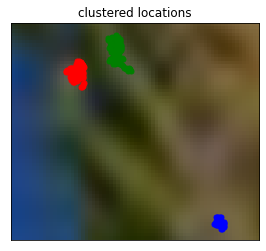

In [7]:
X=np.zeros((329,2))
for i in range(329):
  X[i]=end_id2location[end_ids[i]]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
id2label={}
for i in range(end_ids.shape[0]):
  id2label[end_ids[i]]=kmeans.labels_[i]
colors=[]
colors.append("red")
colors.append("blue")
colors.append("green")

m = Basemap(projection='lcc', resolution=None, lat_0=37.6 ,lon_0=-122.2,width=8E4, height=7E4 )
m.bluemarble(scale=6.5)
plt.title("clustered locations")
for i,id in enumerate(end_ids):
  long_index=0
  lat_index=1
  x, y = m(end_id2location[id][long_index], end_id2location[id][lat_index])
  plt.plot(x, y, 'ok', markersize=5,color=colors[id2label[id]])
del m  # around 7 giga and will not used again 

In [8]:
from_area_to_another=[]
for i in range(data_clean.shape[0]):
  row=data.iloc[i].values
  if id2label[row[3]] !=id2label[row[7]]:
    from_area_to_another.append(i)


# from_area_to_another # too little could be removed easily 
data_clean.drop(from_area_to_another,axis=0,inplace=True)
data_clean["area"]=data_clean.start_station_id.map(id2label)


### user type 
we have a lot more subscribers than customers


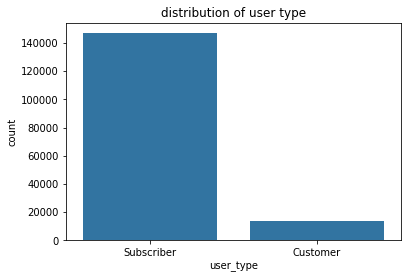

In [9]:
sns.countplot(data=data_clean, x='user_type',color=base_color);
plt.title("distribution of user type");

### member gender
we have a lot males than females

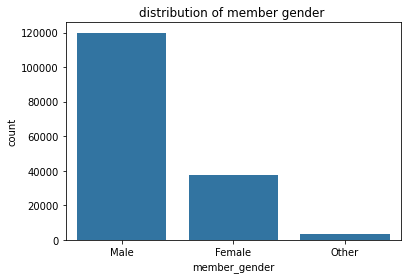

In [10]:
sns.countplot(data=data_clean, x='member_gender',color=base_color);
plt.title("distribution of member gender ");

### member birthyear 
the peak count of birthyears between 1985 to 1995 

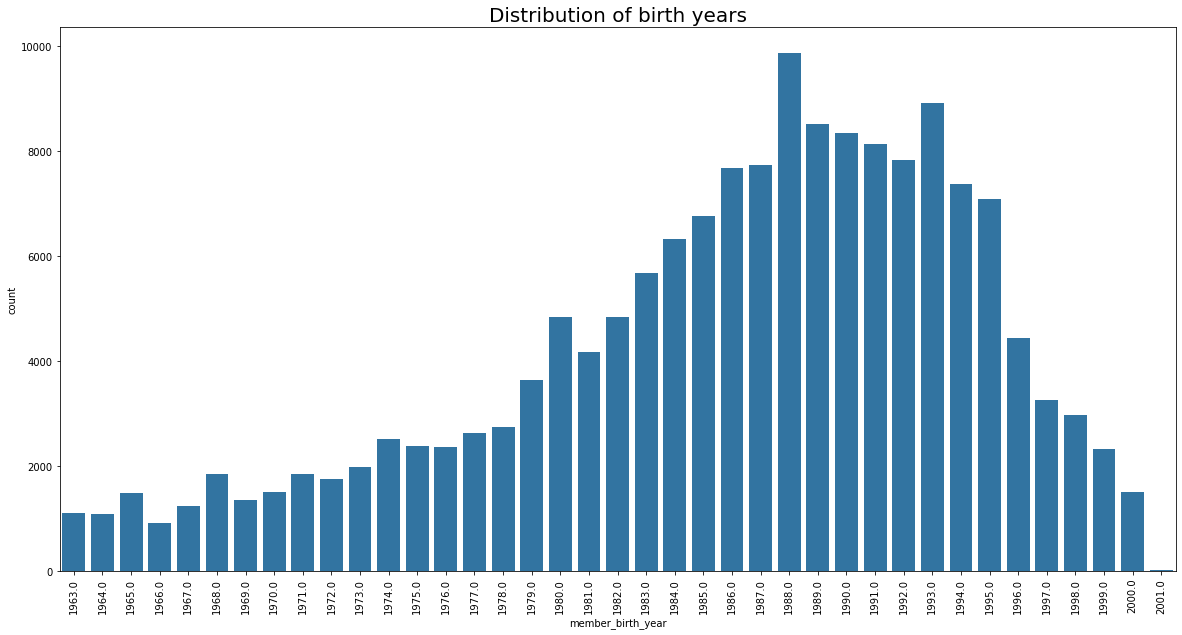

In [11]:
plt.figure(figsize=[20,10])
sns.countplot(data=data_clean, x='member_birth_year',color=base_color);
plt.xticks(rotation=90)
plt.title("Distribution of birth years",fontsize=20);

### bike share

most of the cyclists don't share the bike

Text(0.5, 1.0, 'Distribution of bike share ')

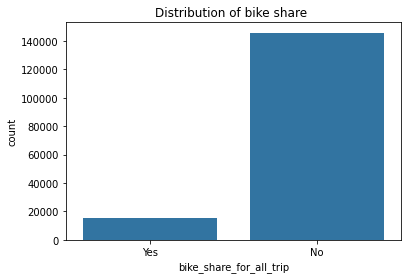

In [12]:
sns.countplot(data=data_clean, x='bike_share_for_all_trip',color=base_color);
plt.title("Distribution of bike share ")

### distance 

Most of the cyclist cycle for around 1 

the number od cyclists starts to decline for more or less than 1 km 

Text(0, 0.5, 'count')

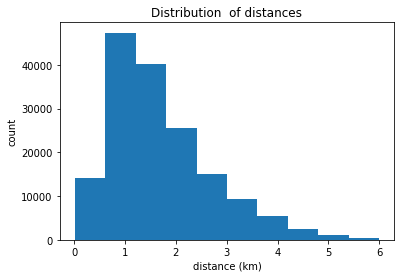

In [13]:
plt.hist(data = data_clean, x = 'distance');
plt.title("Distribution  of distances")
plt.xlabel('distance (km)')
plt.ylabel('count')

### duration

Most of the cyclist cycle for around 500 secounds 

the number od cyclists starts to decline for more or less than 500 sec 

Text(0, 0.5, 'count')

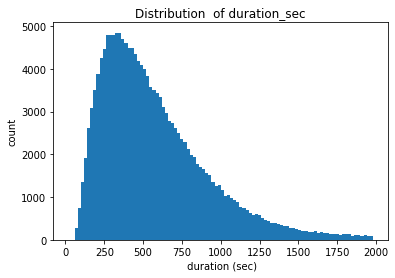

In [14]:
bins=np.arange(20,2000,20)
plt.hist(data = data_clean, x = 'duration_sec',bins=bins);
plt.title("Distribution  of duration_sec")
plt.xlabel(' duration (sec)')
plt.ylabel('count')


## Bivariate 

   removing unused columns 
   
      1 - duration vs gender (box plot & violin plot)
      2 - member birth year vs duration (hear map)
      3 - user type vs duration (box plot & violin plot)
      4 - duration distance  (heatmap )
      5 - bike share - gender (faceting histogram )


removing unused columns

In [15]:
unused_columns=["start_time","end_time","start_station_id","start_station_name","start_station_latitude",
                "start_station_longitude","end_station_id","end_station_name","end_station_latitude","end_station_longitude"]
data_2=data_clean.drop(unused_columns,axis=1)
# data_2.head()

 ### duration vs gender 

the gender doesn't affect the duration but there is a little increase in the female mean duration 







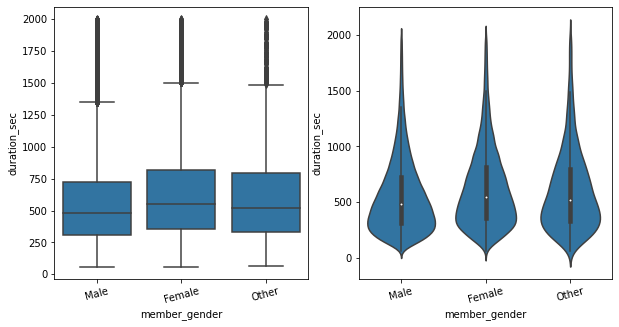

In [16]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
sns.boxplot(data=data_2, x='member_gender', y='duration_sec', color=base_color)
plt.xticks(rotation=15);
plt.subplot(1,2,2)
ax1 = sns.violinplot(data=data_2, x='member_gender', y='duration_sec', color=base_color, innner='quartile')
plt.xticks(rotation=15);
# plt.ylim(ax1.get_ylim()) # set y-axis limits to be same as left plot

  
### member birth year vs duration 

we have a very small number who cycle for more than 1750 sec

most of the cyclist birthdate are between 1985 and 1995 and they cycle for less than 500 secounds may be they use it for small trips
     

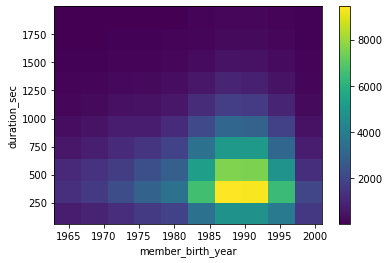

In [17]:
plt.hist2d(data=data_2, x='member_birth_year', y='duration_sec',cmin=0.5) #I didn't notice that before but i think we need to remove some of these birthdates
# sns.boxplot()

plt.colorbar()
plt.xlabel('member_birth_year')
plt.ylabel('duration_sec');


### user type vs duration 

customers usualy cycle for more time than subscribers

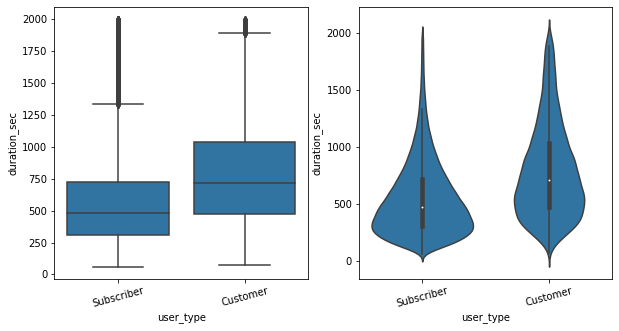

In [18]:
base_color=sns.color_palette()[0]
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
sns.boxplot(data=data_2, x='user_type', y='duration_sec', color=base_color)
plt.xticks(rotation=15);
plt.subplot(1,2,2)
ax1 = sns.violinplot(data=data_2, x='user_type', y='duration_sec', color=base_color, innner='quartile')
plt.xticks(rotation=15);

### duration distance  

surely more distance will need more time so there is a positive corelation 

most of our cyclist doesn't cycle more than 500 sec and around 1 km 


Text(0, 0.5, 'distance')

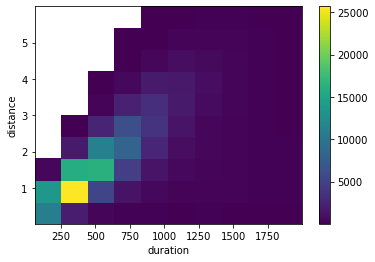

In [19]:
plt.hist2d(data=data_2,  x = 'duration_sec', y = 'distance',cmin=0.5) #positive strong corelation
# sns.boxplot()

plt.colorbar()
plt.xlabel('duration') 
plt.ylabel('distance')

### bike share - gender 

Males usually share more than females 

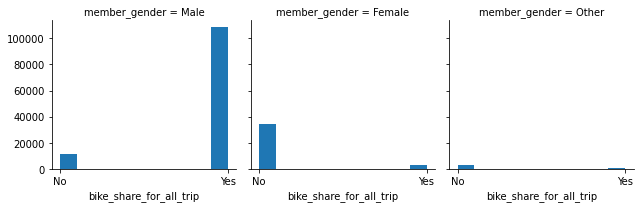

In [20]:
g = sns.FacetGrid(data = data_2, col = 'member_gender')
g.map(plt.hist, "bike_share_for_all_trip")

## multivariate 

#### remove unused columns 

In [21]:
unused_columns=["start_time","end_time","start_station_id","start_station_name","start_station_latitude",
                "start_station_longitude","end_station_id","end_station_name","end_station_latitude","end_station_longitude","bike_id","distance"]
data3=data_clean.drop(unused_columns,axis=1)


area 0 the red one 

area 1 the blue one
 
area 2 the grean one 

area 0 has a lot more cyclits than the two others

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


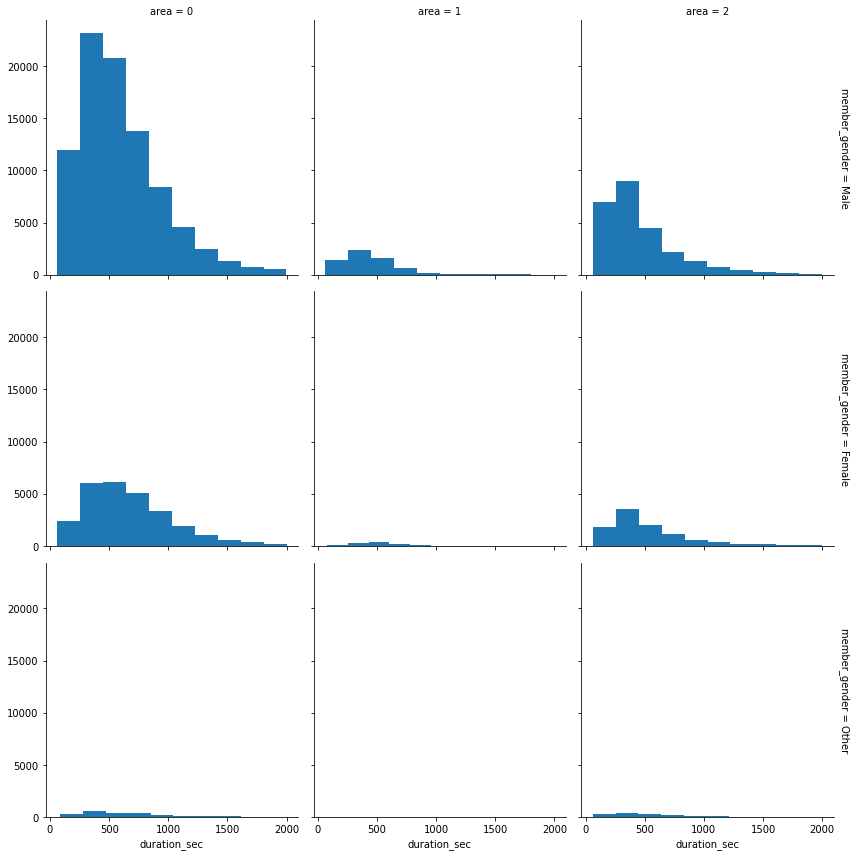

In [22]:
g = sns.FacetGrid(data = data3, col = 'area',row='member_gender', margin_titles = True,size = 4)


g.map(plt.hist,  'duration_sec')
